In [5]:
import os
import sys
import heapq
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import numpy as np
from collections import defaultdict
from P1_util import define_color 
import matplotlib as mpl

### Creación de funcion para representar el laberinto, generar el grafo, resolver el laberinto y presentar la solución

In [6]:
def solve_maze(filename):
    # Agregar el directorio actual al path
    project_path = os.getcwd()  # Obtiene el directorio de trabajo actual
    sys.path.append(project_path)
    
    class MazeLoader:
        def __init__(self, filename):
            self.filename = filename
            self.maze = None

        def load_Maze(self):
            _maze = []
            file_path = os.path.join(project_path, self.filename)  # Usa project_path para asegurar la ruta
            print("Loading Maze from", file_path)
            with open(file_path, 'r') as file:
                for line in file:
                    _maze.append(list(line.strip()))
            self.maze = _maze
            return self

        def plot_maze(self):
            height = len(self.maze)
            width = len(self.maze[0])

            fig = plt.figure(figsize=(width/4, height/4))  # Ajusta el tamaño de la figura según el tamaño del Maze
            for y in range(height):
                for x in range(width):
                    cell = self.maze[y][x]
                    color = define_color(cell)  
                    plt.fill([x, x+1, x+1, x], [y, y, y+1, y+1], color=color, edgecolor='black')

            plt.xlim(0, width)
            plt.ylim(0, height)
            plt.gca().invert_yaxis()  # Invierte el eje y para que el origen esté en la esquina inferior izquierda
            plt.xticks([])
            plt.yticks([])
            fig.tight_layout()
            plt.show()
            return self

        def get_graph(self):
            # Diccionario para almacenar el grafo
            graph = defaultdict(list)
            height = len(self.maze)
            width = len(self.maze[0])

            # Direcciones para moverse: (arriba, abajo, izquierda, derecha)
            directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

            # Recorrer cada celda del laberinto
            for y in range(height):
                for x in range(width):
                    if self.maze[y][x] in [' ', 'E', 'S']:  # Solo considerar espacios transitables
                        # Para cada celda transitable, buscar sus vecinos adyacentes
                        for dx, dy in directions:
                            nx, ny = x + dx, y + dy
                            if 0 <= nx < width and 0 <= ny < height:  # Asegurarse de no salir de los límites
                                if self.maze[ny][nx] in [' ', 'E', 'S']:  # Si el vecino es transitable
                                    graph[(x, y)].append((nx, ny))

            return graph

    # Definir la función heurística
    def heuristic(a, b):
        # Distancia Manhattan
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    # Función para reconstruir el camino
    def reconstruct_path(came_from, current):
        """Reconstruye el camino desde el inicio hasta el objetivo."""
        total_path = [current]
        while current in came_from:
            current = came_from[current]
            total_path.append(current)
        total_path.reverse()
        return total_path

    # Implementación del algoritmo A*
    def astar(maze_loader, start, end):
        graph = maze_loader.get_graph()

        open_set = []
        heapq.heappush(open_set, (0, start))

        came_from = {}
        g_score = {node: float('inf') for node in graph}
        g_score[start] = 0

        f_score = {node: float('inf') for node in graph}
        f_score[start] = heuristic(start, end)

        closed_set = set()

        while open_set:
            _, current = heapq.heappop(open_set)

            if current == end:
                path = reconstruct_path(came_from, current)
                yield {'open_set': set([n for _, n in open_set]),
                       'closed_set': closed_set.copy(),
                       'current': current,
                       'path': path}
                break

            closed_set.add(current)

            yield {'open_set': set([n for _, n in open_set]),
                   'closed_set': closed_set.copy(),
                   'current': current,
                   'path': None}

            for neighbor in graph[current]:
                tentative_g_score = g_score[current] + 1  # Asumimos un costo de 1 por moverse a un vecino

                if tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = g_score[neighbor] + heuristic(neighbor, end)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))

        else:
            yield {'open_set': set(),
                   'closed_set': closed_set.copy(),
                   'current': None,
                   'path': None}

    # Cargar y graficar el laberinto
    maze_loader = MazeLoader(filename).load_Maze()
    maze_loader.plot_maze()
    
    # Obtener el grafo
    graph = maze_loader.get_graph()
    
    # Imprimir el grafo (opcional)
    for node, neighbors in graph.items():
        print(f"Nodo {node}: vecinos {neighbors}")
    
    # Aumentar el límite de tamaño para animaciones
    mpl.rcParams['animation.embed_limit'] = 50  # en MB

    # Encontrar las coordenadas de 'E' (inicio) y 'S' (meta)
    start = None
    end = None
    for y, row in enumerate(maze_loader.maze):
        for x, cell in enumerate(row):
            if cell == 'E':
                start = (x, y)
            elif cell == 'S':
                end = (x, y)
    
    if start and end:
        steps = []
        for step in astar(maze_loader, start, end):
            steps.append(step)

        if not steps:
            print("No se encontraron pasos durante la ejecución de A*.")
        else:
            print("Camino encontrado:", steps[-1]['path'] if steps[-1]['path'] else "No se encontró un camino.")

        # Crear la animación
        maze_array = np.array([[1 if cell == '#' else 0 for cell in row] for row in maze_loader.maze])
        height, width = maze_array.shape

        fig, ax = plt.subplots(figsize=(width / 4, height / 4))
        ax.set_xlim(0, width)
        ax.set_ylim(0, height)
        ax.invert_yaxis()
        ax.set_xticks([])
        ax.set_yticks([])

        # Dibujar el laberinto
        for y in range(height):
            for x in range(width):
                cell = maze_loader.maze[y][x]
                if cell == '#':
                    ax.fill([x, x+1, x+1, x], [y, y, y+1, y+1], color='black')
                elif cell == 'E':
                    ax.text(x + 0.5, y + 0.5, 'E', ha='center', va='center', color='green')
                elif cell == 'S':
                    ax.text(x + 0.5, y + 0.5, 'S', ha='center', va='center', color='red')

        # Inicializar elementos de la gráfica
        open_set_plot, = ax.plot([], [], 'o', color='blue', label='Conjunto Abierto')
        closed_set_plot, = ax.plot([], [], 'o', color='orange', label='Conjunto Cerrado')
        path_plot, = ax.plot([], [], '-', color='cyan', linewidth=3, label='Camino')

        ax.legend(loc='upper right')

        def init_anim():
            open_set_plot.set_data([], [])
            closed_set_plot.set_data([], [])
            path_plot.set_data([], [])
            return open_set_plot, closed_set_plot, path_plot

        def update_anim(frame):
            step = steps[frame]
            open_set = step['open_set']
            closed_set = step['closed_set']
            path = step['path']

            # Coordenadas del conjunto abierto
            open_x = [node[0] + 0.5 for node in open_set]
            open_y = [node[1] + 0.5 for node in open_set]

            # Coordenadas del conjunto cerrado
            closed_x = [node[0] + 0.5 for node in closed_set]
            closed_y = [node[1] + 0.5 for node in closed_set]

            open_set_plot.set_data(open_x, open_y)
            closed_set_plot.set_data(closed_x, closed_y)

            if path:
                path_x = [node[0] + 0.5 for node in path]
                path_y = [node[1] + 0.5 for node in path]
                path_plot.set_data(path_x, path_y)

            return open_set_plot, closed_set_plot, path_plot

        ani = FuncAnimation(fig, update_anim, frames=len(steps),
                            init_func=init_anim, blit=True, interval=200, repeat=False)

        # Mostrar la animación
        display(HTML(ani.to_jshtml()))
    else:
        print("No se encontraron las posiciones de 'E' y 'S'.")

    # Análisis de resultados
    # 1. Contar los espacios visitados
    espacios_visitados = set()
    for paso in steps:
        espacios_visitados.update(paso['closed_set'])
    num_espacios_visitados = len(espacios_visitados)

    # 2. Contar las veces que se hizo backtracking
    # Definimos backtracking como las veces que un nodo fue añadido al 'open_set' más de una vez
    contador_open_set = defaultdict(int)
    for paso in steps:
        for nodo in paso['open_set']:
            contador_open_set[nodo] += 1

    # Calculamos cuántos nodos fueron añadidos al 'open_set' más de una vez
    veces_backtracking = sum(1 for nodo, conteo in contador_open_set.items() if conteo > 1)

    # 3. Contar el número de nodos en la solución
    # Esto es simplemente la longitud del camino encontrado
    if steps and steps[-1]['path']:
        num_nodos_solucion = len(steps[-1]['path'])
    else:
        num_nodos_solucion = 0

    # Mostrar los resultados
    print(f"Espacios visitados: {num_espacios_visitados}")
    print(f"Veces que se hizo backtracking: {veces_backtracking}")
    print(f"Número de nodos en la solución: {num_nodos_solucion}")


### Solución laberinto 1

Loading Maze from C:\Users\59399\PycharmProjects\WorkShopUSFQ\Taller2\P1\A_STAR\laberinto1.txt


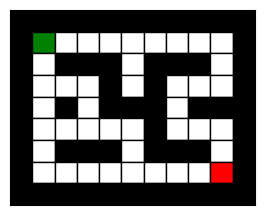

Nodo (1, 1): vecinos [(2, 1), (1, 2)]
Nodo (2, 1): vecinos [(1, 1), (3, 1)]
Nodo (3, 1): vecinos [(2, 1), (4, 1)]
Nodo (4, 1): vecinos [(3, 1), (5, 1)]
Nodo (5, 1): vecinos [(4, 1), (6, 1), (5, 2)]
Nodo (6, 1): vecinos [(5, 1), (7, 1)]
Nodo (7, 1): vecinos [(6, 1), (8, 1)]
Nodo (8, 1): vecinos [(7, 1), (9, 1)]
Nodo (9, 1): vecinos [(8, 1), (9, 2)]
Nodo (1, 2): vecinos [(1, 1), (1, 3)]
Nodo (5, 2): vecinos [(5, 1), (5, 3)]
Nodo (9, 2): vecinos [(9, 1), (9, 3)]
Nodo (1, 3): vecinos [(2, 3), (1, 2), (1, 4)]
Nodo (2, 3): vecinos [(1, 3), (3, 3)]
Nodo (3, 3): vecinos [(2, 3), (3, 4)]
Nodo (5, 3): vecinos [(5, 2)]
Nodo (7, 3): vecinos [(8, 3), (7, 4)]
Nodo (8, 3): vecinos [(7, 3), (9, 3)]
Nodo (9, 3): vecinos [(8, 3), (9, 2)]
Nodo (1, 4): vecinos [(1, 3), (1, 5)]
Nodo (3, 4): vecinos [(3, 3), (3, 5)]
Nodo (7, 4): vecinos [(7, 3), (7, 5)]
Nodo (1, 5): vecinos [(2, 5), (1, 4), (1, 6)]
Nodo (2, 5): vecinos [(1, 5), (3, 5)]
Nodo (3, 5): vecinos [(2, 5), (4, 5), (3, 4)]
Nodo (4, 5): vecinos [(3, 

Espacios visitados: 34
Veces que se hizo backtracking: 16
Número de nodos en la solución: 15


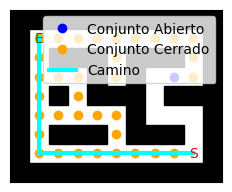

In [7]:
solve_maze('laberinto1.txt')

### Solución laberinto 2

Loading Maze from C:\Users\59399\PycharmProjects\WorkShopUSFQ\Taller2\P1\A_STAR\laberinto2.txt


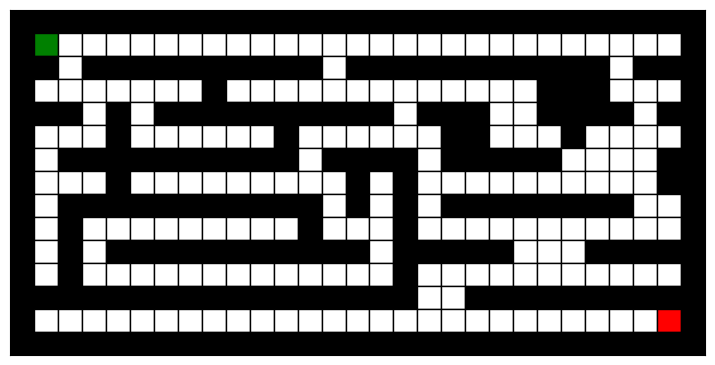

Nodo (1, 1): vecinos [(2, 1)]
Nodo (2, 1): vecinos [(1, 1), (3, 1), (2, 2)]
Nodo (3, 1): vecinos [(2, 1), (4, 1)]
Nodo (4, 1): vecinos [(3, 1), (5, 1)]
Nodo (5, 1): vecinos [(4, 1), (6, 1)]
Nodo (6, 1): vecinos [(5, 1), (7, 1)]
Nodo (7, 1): vecinos [(6, 1), (8, 1)]
Nodo (8, 1): vecinos [(7, 1), (9, 1)]
Nodo (9, 1): vecinos [(8, 1), (10, 1)]
Nodo (10, 1): vecinos [(9, 1), (11, 1)]
Nodo (11, 1): vecinos [(10, 1), (12, 1)]
Nodo (12, 1): vecinos [(11, 1), (13, 1)]
Nodo (13, 1): vecinos [(12, 1), (14, 1), (13, 2)]
Nodo (14, 1): vecinos [(13, 1), (15, 1)]
Nodo (15, 1): vecinos [(14, 1), (16, 1)]
Nodo (16, 1): vecinos [(15, 1), (17, 1)]
Nodo (17, 1): vecinos [(16, 1), (18, 1)]
Nodo (18, 1): vecinos [(17, 1), (19, 1)]
Nodo (19, 1): vecinos [(18, 1), (20, 1)]
Nodo (20, 1): vecinos [(19, 1), (21, 1)]
Nodo (21, 1): vecinos [(20, 1), (22, 1)]
Nodo (22, 1): vecinos [(21, 1), (23, 1)]
Nodo (23, 1): vecinos [(22, 1), (24, 1)]
Nodo (24, 1): vecinos [(23, 1), (25, 1)]
Nodo (25, 1): vecinos [(24, 1), (2

Espacios visitados: 139
Veces que se hizo backtracking: 85
Número de nodos en la solución: 45


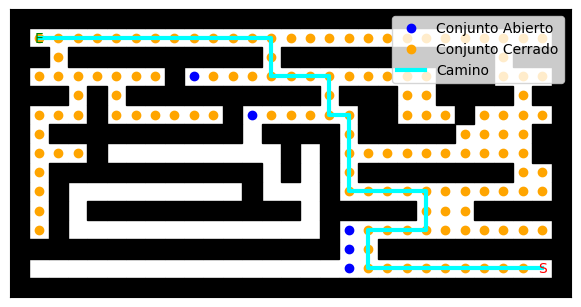

In [8]:
solve_maze('laberinto2.txt')

### Solución laberinto 3

In [ ]:
solve_maze('laberinto3.txt')